### In this notebook, we will use convolutional neural networks to classify letters written by hand.

We will see how to:
- Preprocess images and metadata
- Configure CNN
- Use callbacks performing various actions during CNN training
- Plot the training info 
- Plot the model's predictions on test images
- Save the model to disk

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import os

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

import warnings
warnings.filterwarnings('ignore')

In [2]:
#check version of library
import tensorflow as tf
tf.__version__

'2.3.1'

In [3]:
disk_folder="/kaggle/working/"
folder='/kaggle/input/classification-of-handwritten-letters/'

### Loading the dataframe containing the information about the images

In [4]:
data_info =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [5]:
def import_data(data_info):

  """Creates an additional column: the path to the image"""
  data = pd.read_csv(folder + '/' + data_info)
  data['source'] = data_info[:-4]+'/'
  return data

In [6]:
letters = [import_data(file) for file in data_info]
data = pd.concat(letters, ignore_index=True)

In [7]:
# Shuffle the data 

data = shuffle(data, random_state = 42)

In [8]:
data.head(3)

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/


We see that our dataset contains the following information: the letter, the encoded label, the filename, the background on the paper and the path to the file.

### Target preprocessing 

Since we are going to use neural networks, it would be better to use One-hot encoding rather than ordinal. One-hot encoding means that each class (letter) will be represented by a separate column. The values will be either 0 or 1 depending on whether the image contains the letter.

In [9]:
# Get all labels in one string
letters = '' 
for letter in data.letter.unique():
    letters += letter
    
# Which letter is written on each image
labels = data.label

In [10]:
def ohe_letter(label):
    result = np.zeros(len(letters))
    index = letters.index(label)
    result[index] = 1
    return result

def ohe_background(label):
    result = np.zeros(len(data.background.unique()))
    result[label] = 1
    return result

In [11]:
data['enc_letter'] = data['letter'].apply(ohe_letter)
data['enc_background'] = data['background'].apply(ohe_background)
data.head()

,letter,label,file,background,source,enc_letter,enc_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


### Image preprocessing

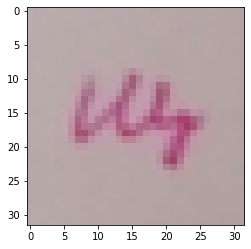

In [12]:
# set the image size
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3) # 3 - число каналов

# let's look at one of the images
image_file_name = folder + 'letters2/27_212.png'
img = image.load_img(image_file_name, target_size=(img_width, img_height))
plt.imshow(img)

In [13]:
# Store all png images into one numpy array
images = []

# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# Want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(folder + row['source'], img_name))
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['enc_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['enc_background'])
        
# Normalize array of images
images = np.array(images)/255

In [14]:
len(images), len(encoded_labels)

(14178, 14178)

## Creating train and test sets

As we are dealing with the classification problem, it's important to make sure that the class distribution is consistent in both train and test sets.

In order to control this, we will use `stratify` -- the parameter of `train_test_split` function.

In [15]:
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11342, 32, 32, 3), (2836, 32, 32, 3), (11342, 33), (2836, 33))

In [16]:
#create generators
datagen = ImageDataGenerator(rescale=1. / 255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
datagen.fit(X_train)

## Configuring of CNN

In [17]:
# The shape of input tensors
input_shape = (img_width, img_height, 3)

# Number of classes to consider
num_classes = len(letters)

# Group of training samples
batch_size = 64

# Number of complete presentations of the dataset to be learned
epochs = 100

In [18]:
# custom metric
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

Now we define our neural network and print its structure as an image.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

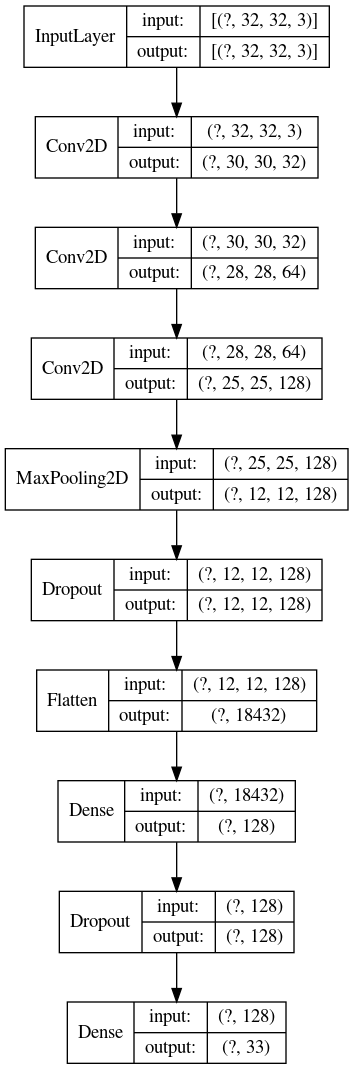

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (4, 4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', top_3_categorical_accuracy])
model.summary()
plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)

In the following cell, we define the callbacks that will make our life a bit easier:
- `ReduceLROnPlateau` will automatically reduce learning rate when a metric has stopped improving
- `ModelCheckpoint` will save the best model to disk so we can re-use it later.



In [20]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)


model_checkpoint= ModelCheckpoint(disk_folder+"/best_result_checkpoint", monitor='val_loss', save_best_only=True, verbose=0)



Finally, it's time to train our CNN.

Make sure you have enabled GPU, as the training will take a considerable amount of time!

In [21]:
%%time

history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [model_checkpoint, lr_reduction])

Epoch 1/100
178/178 [==============================] - 3s 18ms/step - loss: 3.4801 - accuracy: 0.0399 - top_3_categorical_accuracy: 0.1131 - val_loss: 3.3920 - val_accuracy: 0.0793 - val_top_3_categorical_accuracy: 0.1883
Epoch 2/100
178/178 [==============================] - 3s 16ms/step - loss: 2.8848 - accuracy: 0.1869 - top_3_categorical_accuracy: 0.3931 - val_loss: 2.2827 - val_accuracy: 0.3565 - val_top_3_categorical_accuracy: 0.5945
Epoch 3/100
178/178 [==============================] - 3s 15ms/step - loss: 2.3200 - accuracy: 0.3383 - top_3_categorical_accuracy: 0.5760 - val_loss: 2.0015 - val_accuracy: 0.4489 - val_top_3_categorical_accuracy: 0.6848
Epoch 4/100
178/178 [==============================] - 3s 15ms/step - loss: 1.9692 - accuracy: 0.4297 - top_3_categorical_accuracy: 0.6669 - val_loss: 1.6404 - val_accuracy: 0.5504 - val_top_3_categorical_accuracy: 0.7627
Epoch 5/100
178/178 [==============================] - 3s 16ms/step - loss: 1.6683 - accuracy: 0.5120 - top_3_ca

## Plot the training info

Let's look at the training process.

This plot shows how the accuracy changed over epochs on both train and val sets.

[0.039851877838373184, 0.18691588938236237, 0.33830010890960693, 0.42973020672798157, 0.5119908452033997, 0.5675365924835205, 0.6189384460449219, 0.6534121036529541, 0.6880620718002319, 0.7041085958480835, 0.7250925898551941, 0.7393757700920105, 0.7548051476478577, 0.7605360746383667, 0.772703230381012, 0.794304370880127, 0.7971257567405701, 0.8063833713531494, 0.8056780099868774, 0.8191676735877991, 0.8327455520629883, 0.8330982327461243, 0.8416504859924316, 0.8486157655715942, 0.8577852249145508, 0.8572562336921692, 0.8592841029167175, 0.8664256930351257, 0.8681008815765381, 0.8722447752952576, 0.8746252655982971, 0.8799153566360474, 0.8875859379768372, 0.8860871195793152, 0.8892611265182495, 0.8954328894615173, 0.900193989276886, 0.9083935618400574, 0.905572235584259, 0.9075118899345398, 0.9110386371612549, 0.91535884141922, 0.9147416949272156, 0.9196790456771851, 0.9222359657287598, 0.9170340299606323, 0.921442449092865, 0.9262916445732117, 0.9354611039161682, 0.9372244477272034, 0

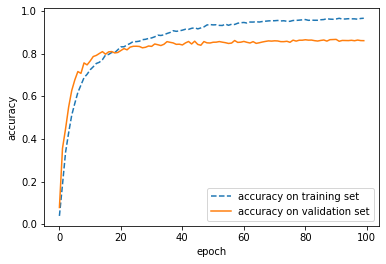

In [22]:
print(history.history['accuracy'])

plt.plot(history.history['accuracy'],'--', label='accuracy on training set')
plt.plot(history.history['val_accuracy'], label='accuracy on validation set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

We can also see how the loss was changing.

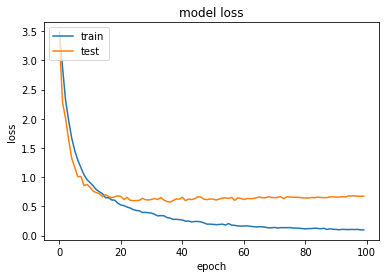

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Finally, we can also see the change of the learning rate.

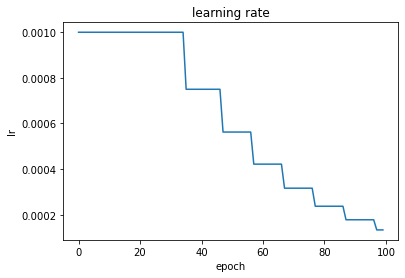

In [24]:
plt.plot(history.history['lr'])
plt.title('learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()

Now let's restore model from the checkpoint it was saved to.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

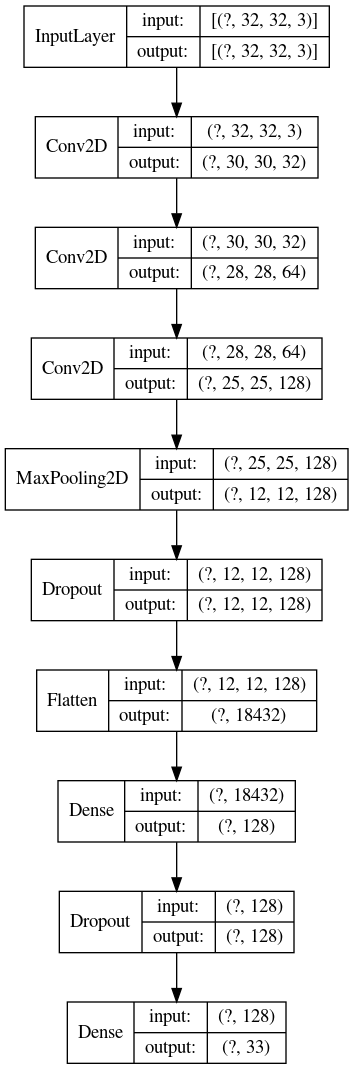

In [25]:
cnn_model=models.load_model(disk_folder+"/best_result_checkpoint",
                            custom_objects={'top_3_categorical_accuracy':top_3_categorical_accuracy}) 
cnn_model.summary()
plot_model(cnn_model, expand_nested=True, show_shapes=True, show_layer_names=False)

## Evaluating the model

Let's evaluate the model performance on the test set.

In [26]:
loss, acc, top3_cat_acc = cnn_model.evaluate(X_val, y_val)
print("loss", loss)
print("acc", acc)
print("top 3 category acc", top3_cat_acc)

89/89 [==============================] - 0s 3ms/step - loss: 0.5731 - accuracy: 0.8540 - top_3_categorical_accuracy: 0.9538
loss 0.5731419920921326
acc 0.8540197610855103
top 3 category acc 0.9538081884384155


### Plot the model's predictions on the test set

And at last the most interesting part -- the model's predicitions!

In [27]:
def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]


def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []
    
    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = folder +'letters/'
        else:
            path = folder +'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))
        
        index_image = random.randint(0, len(os.listdir(path)))
        
        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)
        
    return images, true_labels, true_backgrounds

def classes_predictions(images_list_to_classify, true_labels, model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        a_letter = model.predict_classes(image)
        associated_letter = letters[a_letter[0]]
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()

In [28]:
test_images, true_labels, true_backgrounds = load_random_images()

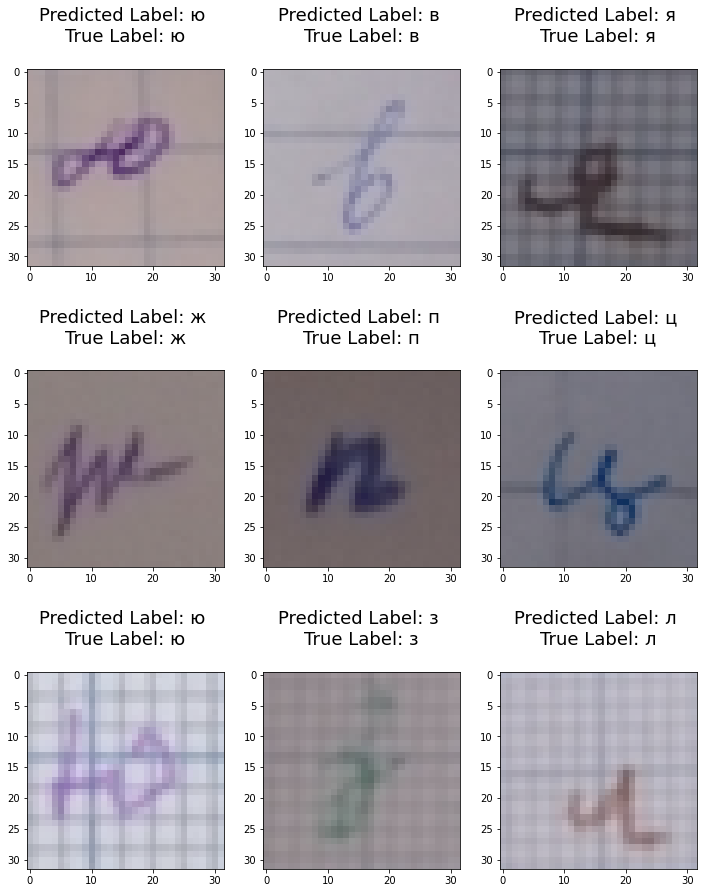

In [29]:
classes_predictions(test_images, true_labels, cnn_model)

## Saving the model

When we are happy with the model's results, we can save the model to a file. We can also save weights and structure in different files.

In [30]:
#save model
model_json = cnn_model.to_json()
json_file = open(disk_folder+"/my_model" + ".json", "w")
#write structure
json_file.write(model_json)
json_file.close()
# write wtights
model.save_weights(disk_folder+"/my_model"+".h5")
print("saving done")

saving done


## That's it! Hope you find this quick notebook useful :)